<a href="https://colab.research.google.com/github/pandi2833/FinalProjectRM/blob/main/Cyber_Attacks_Prediction_(%2BHybrid_Feature_Selection)_0_6_RM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import pyarrow.parquet as pa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import time

# Importing Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d dhoogla/cicids2017

Dataset URL: https://www.kaggle.com/datasets/dhoogla/cicids2017
License(s): CC-BY-NC-SA-4.0
... resuming from 41943040 bytes (195982665 bytes left) ...
 98% 222M/227M [00:02<00:00, 96.1MB/s]
100% 227M/227M [00:02<00:00, 86.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cicids2017.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df_data_1 = pd.read_parquet('/content/Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('/content/Botnet-Friday-no-metadata.parquet')
df_data_3 = pd.read_parquet('/content/Bruteforce-Tuesday-no-metadata.parquet')
df_data_4 = pd.read_parquet('/content/DDoS-Friday-no-metadata.parquet')
df_data_5 = pd.read_parquet('/content/DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('/content/Infiltration-Thursday-no-metadata.parquet')
df_data_7 = pd.read_parquet('/content/Portscan-Friday-no-metadata.parquet')
df_data_8 = pd.read_parquet('/content/WebAttacks-Thursday-no-metadata.parquet')

In [ ]:
df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4,
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

In [ ]:
df_data.shape

(2313810, 78)

In [ ]:
df_data['Label'].value_counts()

,count
Label,
Benign,1977318
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
df_data['Label'].unique()

array(['Benign', 'Bot', 'FTP-Patator', 'SSH-Patator', 'DDoS',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed', 'Infiltration', 'PortScan',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

# Data Undersampling

In [ ]:
df_data.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [ ]:
benign_total = len(df_data[df_data['Label'] == "Benign"])
benign_total

1977318

In [ ]:
attack_total = len(df_data[df_data['Label'] != "Benign"])
attack_total

336492

In [ ]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

785148.0 0.43678497844049363


In [ ]:
import random
indexes = []
benign_included_count = 0
for index, row in df_data.iterrows():
    if (row['Label'] != "Benign"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df_data.loc[indexes]

In [ ]:
df_balanced['Label'].value_counts()

,count
Label,
Benign,785149
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
benign_total_new = len(df_balanced[df_balanced['Label'] == "Benign"])
benign_total_new

785149

In [ ]:
attack_total_new = len(df_balanced[df_balanced['Label'] != "Benign"])
attack_total_new

336492

In [ ]:
benign_total = len(df_data[df_data['Label'] == "Benign"])
benign_total

1977318

In [ ]:
attack_total = len(df_data[df_data['Label'] != "Benign"])
attack_total

336492

In [ ]:
df_data['Label'].value_counts()

,count
Label,
Benign,1977318
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

# Prepare Data for Training and Testing

In [ ]:
df = pd.read_csv('web_attacks_balanced.csv')

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [ ]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(1121641, 77) (1121641,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Importance

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 549458, 1: 235690}

## Visualization of Decision Tree

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.96501305, 0.96417245, 0.96441444, 0.96512768, 0.96412151,
       0.96354837, 0.96409603, 0.96311533, 0.963688  , 0.96435031])

In [ ]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Bwd Packet Length Std <= 1495.68
|   |--- Bwd Packets/s <= 0.03
|   |   |--- Subflow Fwd Packets <= 3.50
|   |   |   |--- class: 0
|   |   |--- Subflow Fwd Packets >  3.50
|   |   |   |--- class: 1
|   |--- Bwd Packets/s >  0.03
|   |   |--- FIN Flag Count <= 0.50
|   |   |   |--- class: 0
|   |   |--- FIN Flag Count >  0.50
|   |   |   |--- class: 1
|--- Bwd Packet Length Std >  1495.68
|   |--- class: 1



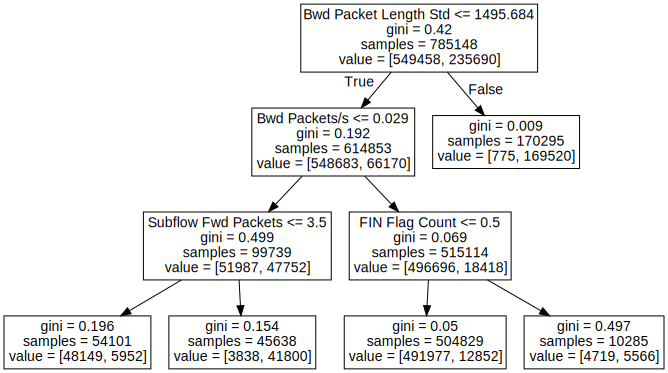

In [ ]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 235691, 1: 100802}

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[231757,   3934],
       [  8047,  92755]])

## SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.7493684 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11690874, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01911105, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11461181, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
sfm.threshold_

0.012987012987012988

In [ ]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 77, selected num features: 4


In [ ]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Bwd Packet Length Std - 0.7493684003927721
1.	Bwd Packets/s - 0.11690873684123466
2.	Subflow Fwd Packets - 0.1146118096027781
3.	FIN Flag Count - 0.0191110531632152
4.	Bwd IAT Std - 0.0
5.	Fwd IAT Mean - 0.0
6.	Fwd IAT Std - 0.0
7.	Fwd IAT Max - 0.0
8.	Fwd IAT Min - 0.0
9.	Bwd IAT Total - 0.0


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00 
Out-of-bag Score: 1.00


In [ ]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#54	0.087	Avg Bwd Segment Size
2.	#13	0.077	Bwd Packet Length Std
3.	#12	0.061	Bwd Packet Length Mean
4.	#41	0.060	Packet Length Std
5.	#10	0.060	Bwd Packet Length Max
6.	#42	0.057	Packet Length Variance
7.	#5	0.040	Bwd Packets Length Total
8.	#52	0.038	Avg Packet Size
9.	#39	0.031	Packet Length Max
10.	#40	0.028	Packet Length Mean
11.	#64	0.028	Subflow Bwd Bytes
12.	#37	0.028	Bwd Packets/s
13.	#2	0.023	Total Fwd Packets
14.	#22	0.023	Fwd IAT Std
15.	#61	0.022	Subflow Fwd Packets
16.	#23	0.021	Fwd IAT Max
17.	#34	0.018	Fwd Header Length
18.	#15	0.017	Flow Packets/s
19.	#3	0.014	Total Backward Packets
20.	#35	0.014	Bwd Header Length


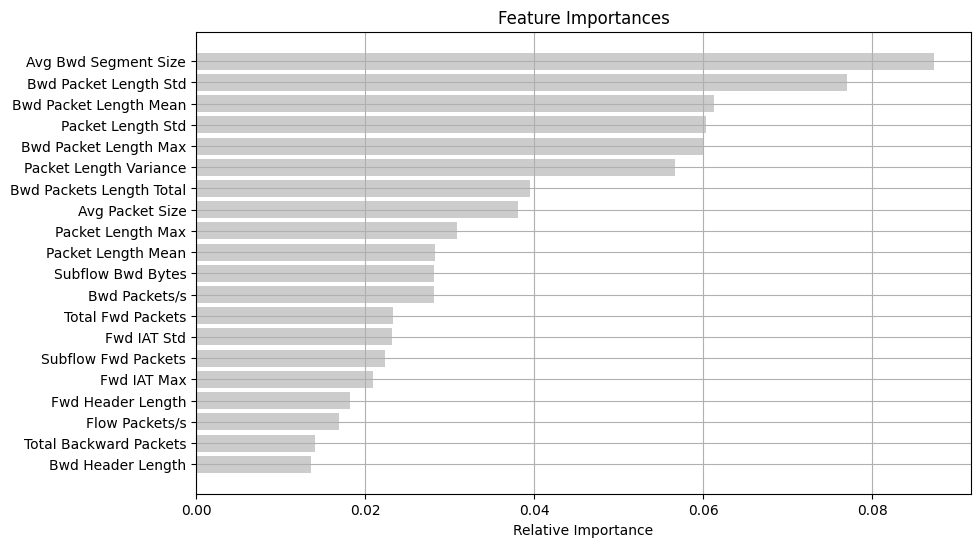

In [ ]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[235466,    225],
       [   342, 100460]])

In [ ]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Avg Bwd Segment Size',
 'Bwd Packet Length Std',
 'Bwd Packet Length Mean',
 'Packet Length Std',
 'Bwd Packet Length Max',
 'Packet Length Variance',
 'Bwd Packets Length Total',
 'Avg Packet Size',
 'Packet Length Max',
 'Packet Length Mean',
 'Subflow Bwd Bytes',
 'Bwd Packets/s',
 'Total Fwd Packets',
 'Fwd IAT Std',
 'Subflow Fwd Packets',
 'Fwd IAT Max',
 'Fwd Header Length',
 'Flow Packets/s',
 'Total Backward Packets',
 'Bwd Header Length']

# Feature Selection

## Filter Method

Correlation Filter Method

In [ ]:
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

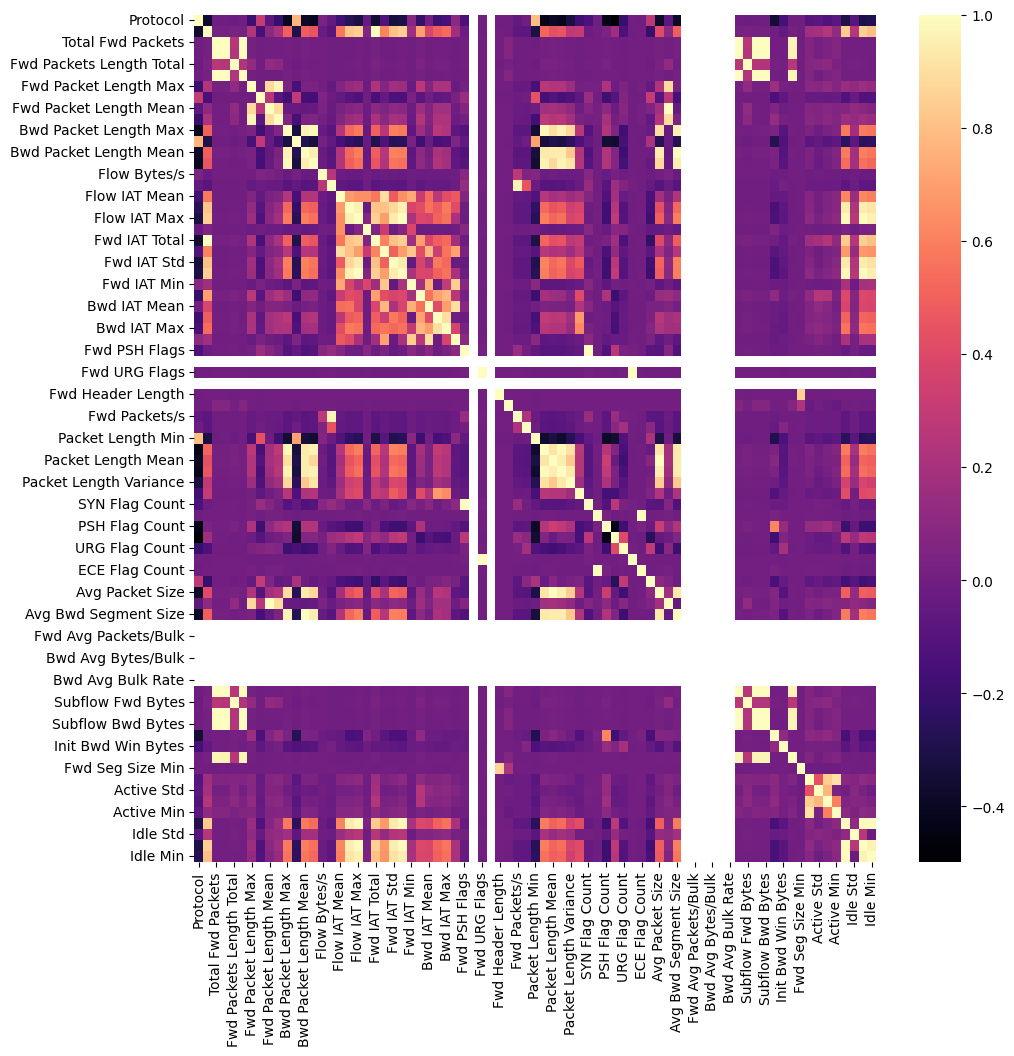

In [ ]:
corr_mat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corr_mat, cmap='magma');

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(0, len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.6)
len(set(corr_features))

45

In [ ]:
X_train_filter = X_train.drop(labels=set(corr_features), axis=1)
X_test_filter = X_test.drop(labels=set(corr_features), axis=1)

print(X_train_filter.shape, X_test_filter.shape)

(785148, 32) (336493, 32)


In [ ]:
print(X_train_filter)
print(X_test_filter)

         Protocol  Flow Duration  Total Fwd Packets  Fwd Packets Length Total  \
907475         17          62104                  2                        90   
850520         17          91802                  2                        68   
382889          6         900256                  7                       358   
853464         17          30446                  1                        44   
1101829         6            732                  2                         8   
...           ...            ...                ...                       ...   
110268          6        5065033                  7                       635   
259178          6         241011                  4                      1253   
131932         17            334                  2                        94   
671155          6       85002037                  6                       342   
121958          6       74485773                243                      5577   

         Fwd Packet Length 

## Wrapper Method

Step Forward Feature Selection

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(X_train_filter)
print(y_train)

         Protocol  Flow Duration  Total Fwd Packets  Fwd Packets Length Total  \
907475         17          62104                  2                        90   
850520         17          91802                  2                        68   
382889          6         900256                  7                       358   
853464         17          30446                  1                        44   
1101829         6            732                  2                         8   
...           ...            ...                ...                       ...   
110268          6        5065033                  7                       635   
259178          6         241011                  4                      1253   
131932         17            334                  2                        94   
671155          6       85002037                  6                       342   
121958          6       74485773                243                      5577   

         Fwd Packet Length 

In [ ]:
sfs = SFS(RandomForestClassifier(n_jobs=8),
          k_features=5,
          forward=True,
          floating=False,
          verbose=2,
          scoring='roc_auc',
          cv=3)

sfs = sfs.fit(X_train_filter, y_train)


[2024-08-21 01:12:29] Features: 1/5 -- score: 0.9689112206677115
[2024-08-21 01:27:27] Features: 2/5 -- score: 0.9960198350233028
[2024-08-21 01:40:33] Features: 3/5 -- score: 0.9991877841975371
[2024-08-21 01:55:01] Features: 4/5 -- score: 0.9996161968181227
[2024-08-21 02:10:44] Features: 5/5 -- score: 0.9996309623603743

In [ ]:
selected_feat = X_train_filter.columns[list(sfs.k_feature_idx_)]
print(selected_feat)

Index(['Fwd Packet Length Max', 'Bwd Packet Length Max', 'Fwd Header Length',
       'ACK Flag Count', 'Init Bwd Win Bytes'],
      dtype='object')


In [ ]:
X_train_wrapper = X_train_filter[selected_feat]
X_test_wrapper = X_test_filter[selected_feat]

In [ ]:
X_train_selected = X_train_wrapper
X_test_selected = X_test_wrapper

# Model Training and Evaluation

## Decision Tree

Training

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_selected, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_train_pred_dt = dt.predict(X_train_selected)

In [ ]:
# Decision Tree Model Evaluation for Data Training
start_time = time.time()

accuracy_dt_training = metrics.accuracy_score(y_train, y_train_pred_dt)
precision_dt_training = metrics.precision_score(y_train, y_train_pred_dt)
recall_dt_training = metrics.recall_score(y_train, y_train_pred_dt)
f1_dt_training = metrics.f1_score(y_train, y_train_pred_dt)

print("Metrics with Selected Features for Data Training:")
print('Accuracy =', accuracy_dt_training)
print('Precision =', precision_dt_training)
print('Recall =', recall_dt_training)
print('F1 =', f1_dt_training)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Data Training:
Accuracy = 0.9921696291654567
Precision = 0.9901769011967096
Recall = 0.9836734693877551
F1 = 0.9869144715557902
Computing time: 1.0382678508758545 seconds


Testing

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_test_selected, y_test)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_test_pred_dt = dt.predict(X_test_selected)

In [ ]:
# Decision Tree Model Evaluation for Data Testing
start_time = time.time()

accuracy_dt_testing = metrics.accuracy_score(y_test, y_test_pred_dt)
precision_dt_testing = metrics.precision_score(y_test, y_test_pred_dt)
recall_dt_testing = metrics.recall_score(y_test, y_test_pred_dt)
f1_dt_testing = metrics.f1_score(y_test, y_test_pred_dt)

print("Metrics with Selected Features for Data Testing:")
print('Accuracy =', accuracy_dt_testing)
print('Precision =', precision_dt_testing)
print('Recall =', recall_dt_testing)
print('F1 =', f1_dt_testing)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Data Testing:
Accuracy = 0.9920919603082382
Precision = 0.9898379867634287
Recall = 0.9837007202238051
F1 = 0.9867598107264939
Computing time: 0.40349531173706055 seconds


## Random Forest

Training

In [ ]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
rfc.fit(X_train_selected, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
y_train_pred_rf = rfc.predict(X_train_selected)

In [ ]:
# Random Forest Model Evaluation for Data Training
start_time = time.time()

accuracy_rf_training = metrics.accuracy_score(y_train, y_train_pred_rf)
precision_rf_training = metrics.precision_score(y_train, y_train_pred_rf)
recall_rf_training = metrics.recall_score(y_train, y_train_pred_rf)
f1_rf_training = metrics.f1_score(y_train, y_train_pred_rf)

print("Metrics with Selected Features for Data Training:")
print('Accuracy =', accuracy_rf_training)
print('Precision =', precision_rf_training)
print('Recall =', recall_rf_training)
print('F1 =', f1_rf_training)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Data Training:
Accuracy = 0.9919938661246033
Precision = 0.989882208232611
Recall = 0.9833807119521405
F1 = 0.9866207495445181
Computing time: 1.0325450897216797 seconds


Testing

In [ ]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
rfc.fit(X_test_selected, y_test)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
y_test_pred_rf = rfc.predict(X_test_selected)

In [ ]:
# Random Forest Model Evaluation for Data Testing
start_time = time.time()

accuracy_rf_testing = metrics.accuracy_score(y_test, y_test_pred_rf)
precision_rf_testing = metrics.precision_score(y_test, y_test_pred_rf)
recall_rf_testing = metrics.recall_score(y_test, y_test_pred_rf)
f1_rf_testing = metrics.f1_score(y_test, y_test_pred_rf)

print("Metrics with Selected Features for Testing Data:")
print('Accuracy =', accuracy_rf_testing)
print('Precision =', precision_rf_testing)
print('Recall =', recall_rf_testing)
print('F1 =', f1_rf_testing)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Testing Data:
Accuracy = 0.9918304392661957
Precision = 0.9893206112203448
Recall = 0.9833435844526894
F1 = 0.9863230428617628
Computing time: 0.41594767570495605 seconds


## XGBoost

Training

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_train_pred_xgb = xgb.predict(X_train_selected)

In [ ]:
# XGBoost Model Evaluation for Data Training
start_time = time.time()

accuracy_xgb_training = metrics.accuracy_score(y_train, y_train_pred_xgb)
precision_xgb_training = metrics.precision_score(y_train, y_train_pred_xgb)
recall_xgb_training = metrics.recall_score(y_train, y_train_pred_xgb)
f1_xgb_training = metrics.f1_score(y_train, y_train_pred_xgb)

print("Metrics with Selected Features for Data Training:")
print('Accuracy =', accuracy_xgb_training)
print('Precision =', precision_xgb_training)
print('Recall =', recall_xgb_training)
print('F1 =', f1_xgb_training)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Data Training:
Accuracy = 0.9918155557933027
Precision = 0.9898342890839322
Recall = 0.9828291399719972
F1 = 0.9863192764928297
Computing time: 1.0135283470153809 seconds


Testing

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_test_selected, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_test_pred_xgb = xgb.predict(X_test_selected)

In [ ]:
# XGBoost Model Evaluation for Data Testing
start_time = time.time()

accuracy_xgb_testing = metrics.accuracy_score(y_test, y_test_pred_xgb)
precision_xgb_testing = metrics.precision_score(y_test, y_test_pred_xgb)
recall_xgb_testing = metrics.recall_score(y_test, y_test_pred_xgb)
f1_xgb_testing = metrics.f1_score(y_test, y_test_pred_xgb)

print("Metrics with Selected Features for Testing Data:")
print('Accuracy =', accuracy_xgb_testing)
print('Precision =', precision_xgb_testing)
print('Recall =', recall_xgb_testing)
print('F1 =', f1_xgb_testing)

end_time = time.time()
computing_time = end_time - start_time
print("Computing time:", computing_time, "seconds")

Metrics with Selected Features for Testing Data:
Accuracy = 0.991693735085128
Precision = 0.9907170967645027
Recall = 0.9814686216543322
F1 = 0.9860711740579977
Computing time: 0.41877031326293945 seconds


# ROC

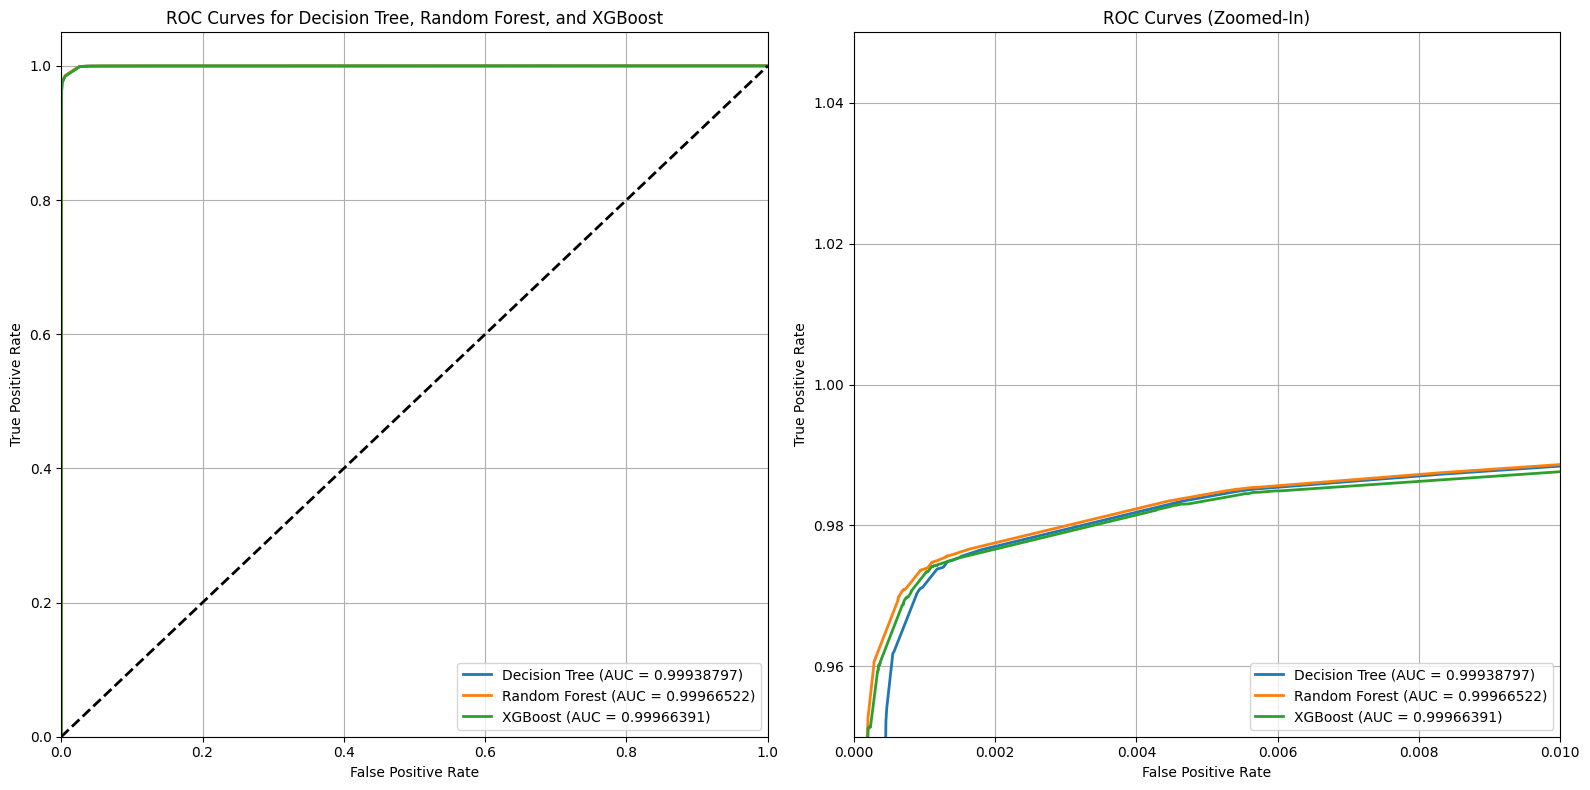

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Assuming X_train_selected, y_train, X_test_selected, and y_test are already defined

# Initialize the classifiers
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the classifiers on the selected features
dt_clf.fit(X_train_selected, y_train)
rf_clf.fit(X_train_selected, y_train)
xgb_clf.fit(X_train_selected, y_train)

# Calculate ROC curves and AUCs for each model
# Decision Tree
y_test_prob_dt = dt_clf.predict_proba(X_test_selected)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest
y_test_prob_rf = rf_clf.predict_proba(X_test_selected)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost
y_test_prob_xgb = xgb_clf.predict_proba(X_test_selected)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting
plt.figure(figsize=(16, 8))

# Subplot 1: Standard ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree, Random Forest, and XGBoost')
plt.legend(loc="lower right")
plt.grid()

# Subplot 2: Zoomed-In ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Zooming in on the top-left corner
plt.xlim([0.0, 0.01])
plt.ylim([0.95, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed-In)')
plt.legend(loc="lower right")
plt.grid()

plt.tight_layout()
plt.show()


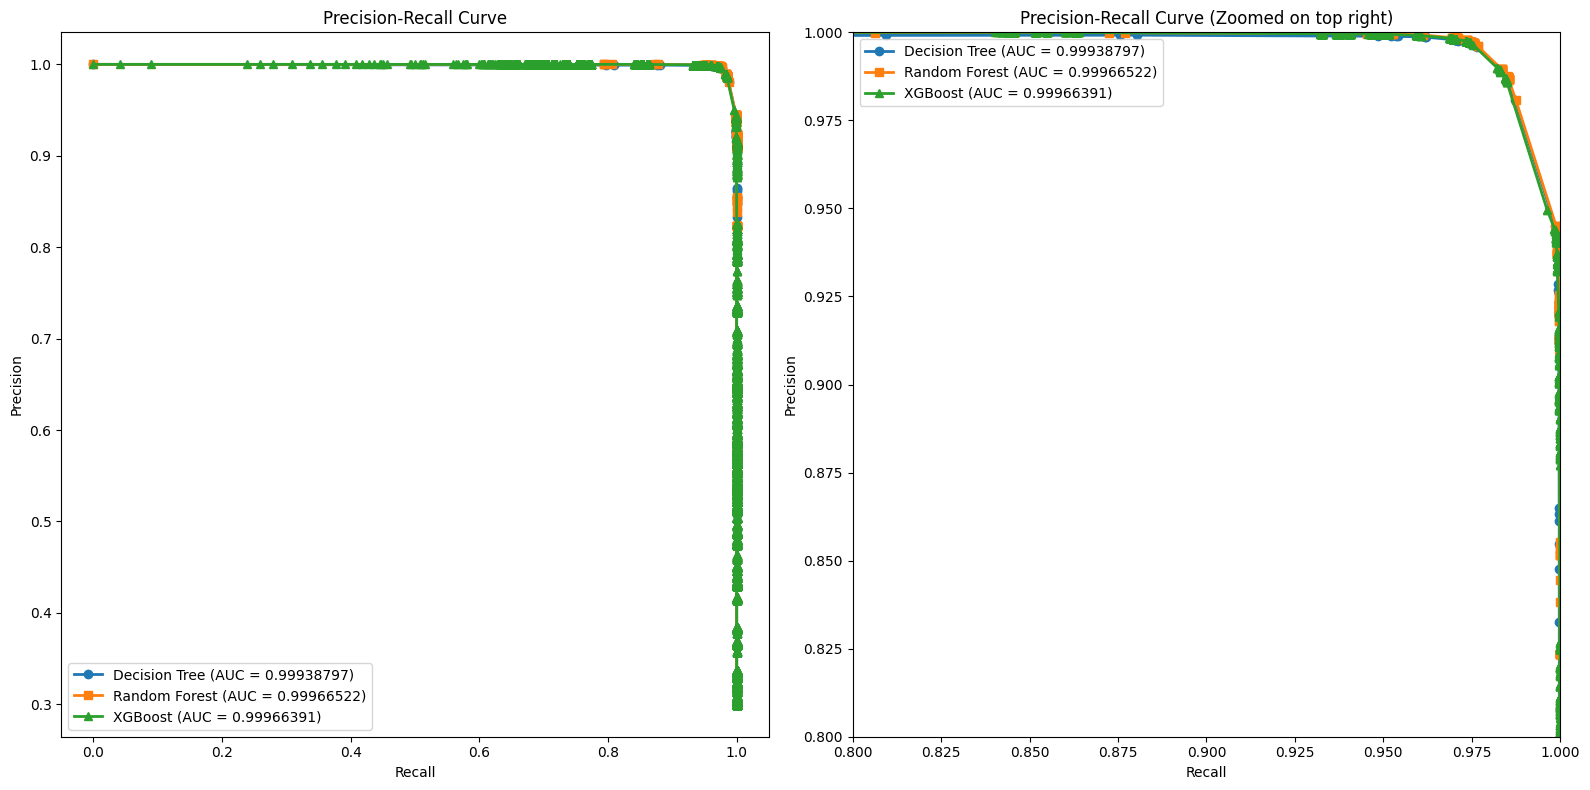

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve using the same probability predictions
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_test_prob_dt)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_prob_xgb)

# Plot the standard Precision-Recall curve
plt.figure(figsize=(16, 8))

# Subplot 1: Standard Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_dt, precision_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")

# Subplot 2: Zoomed-In Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_dt, precision_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')

# Zoom in on the top-right corner
plt.xlim([0.8, 1.0])
plt.ylim([0.8, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Zoomed on top right)')
plt.legend(loc="best")

plt.tight_layout()
plt.show()


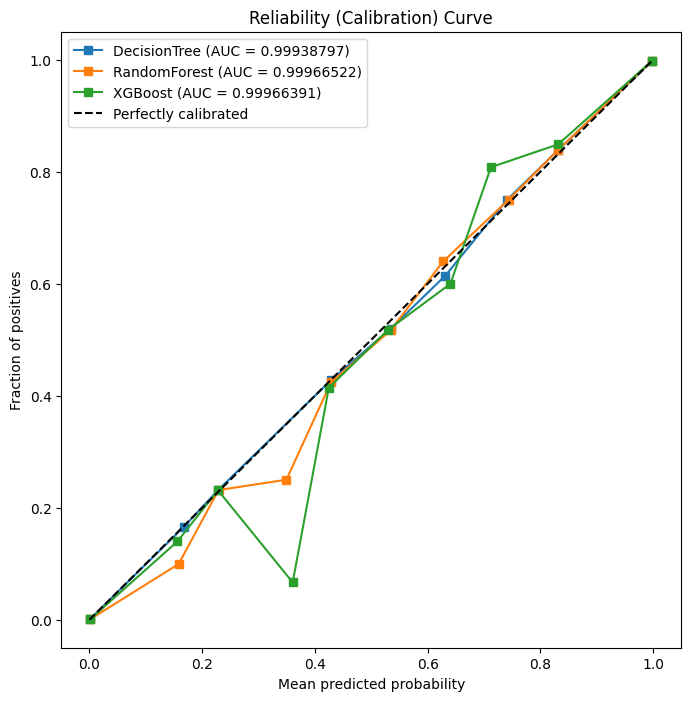

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Function to plot the reliability curve
def plot_reliability_curve(y_test, y_prob, model_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{model_name}")

# Get predicted probabilities using the same variables from the ROC code
y_prob_dt = dt_clf.predict_proba(X_test_selected)[:, 1]
y_prob_rf = rf_clf.predict_proba(X_test_selected)[:, 1]
y_prob_xgb = xgb_clf.predict_proba(X_test_selected)[:, 1]

# Plot the reliability curve
plt.figure(figsize=(8, 8))
plot_reliability_curve(y_test, y_prob_dt, f"DecisionTree (AUC = {roc_auc_dt:.8f})")
plot_reliability_curve(y_test, y_prob_rf, f"RandomForest (AUC = {roc_auc_rf:.8f})")
plot_reliability_curve(y_test, y_prob_xgb, f"XGBoost (AUC = {roc_auc_xgb:.8f})")

# Reference line for perfect calibration
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability (Calibration) Curve")
plt.legend(loc="best")
plt.show()
